<h1>Detección de rostros aplicando HOG<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Muestras-de-entrenamiento-positivas" data-toc-modified-id="Muestras-de-entrenamiento-positivas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Muestras de entrenamiento positivas</a></span></li><li><span><a href="#Muestras-de-entrenamiento-negativas" data-toc-modified-id="Muestras-de-entrenamiento-negativas-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Muestras de entrenamiento negativas</a></span></li><li><span><a href="#Combinar-muestras-y-extraer-características-HOG" data-toc-modified-id="Combinar-muestras-y-extraer-características-HOG-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Combinar muestras y extraer características HOG</a></span></li><li><span><a href="#Entrenando-el-modelo-SVM" data-toc-modified-id="Entrenando-el-modelo-SVM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Entrenando el modelo SVM</a></span></li><li><span><a href="#Probando-nuevas-imágenes" data-toc-modified-id="Probando-nuevas-imágenes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Probando nuevas imágenes</a></span></li></ul></div>

En este notebook vamos a intentar resolver el problema de detección de rostros aplicando HOG.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from skimage import data, color, feature, transform
from sklearn.datasets import fetch_lfw_people
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

En el mundo real, las imágenes no son fáciles de tratar por múltiples razones. Existe mucha literatura referente a la extracción de características. Una de esas técnicas es el Histograma de Gradientes Orientados (**HOG**), que transforma los pixeles en una representación vectorial, sensible a características importantes en lugar de a factores que confunden, como la iluminación.

Características de HOG:
 * Pre-normalización opcional de las imágenes, que consigue características resistentes a la variación de iluminación
 * Convolución de la imagen con dos filtros que capturan bordes, contornos y textura; sensibles al gradiente horizontal y vertical del brillo
 * Subdivisión de la imagen en celdas de un tamaño predeterminado, y cálculo del histograma de gradientes orientados para cada celda
 * Normalización de los histogramas, comparando con las celdas vecinas. Esto suprime los efectos de la iluminación
 * Construcción de un vector unidimensional con la información de cada celda
 
Vemos un ejemplo usando Scikit-Image: 

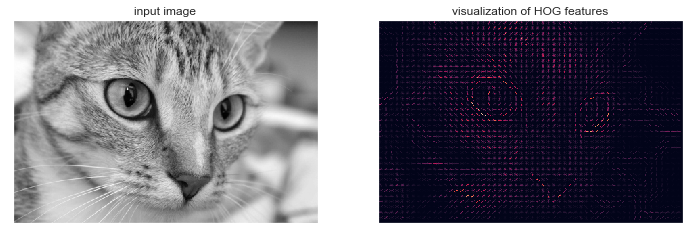

In [2]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True, block_norm='L1')

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

Podemos construir un algoritmo simple para detección facial con cualquier estimador de Scikit-Learn, usando HOG. En este ejemplo usaremos SVM, siguiendo estos pasos:
 1. Obtener un conjunto de imágenes de rostros como muestras de entrenamiento "positivas"
 2. Obtener un conjunto de imágenes distintas como muestras negativas
 3. Extraer las características de HOG a partir de las muestras
 4. Entrenar un clasificador SVM lineal sobre estas muestras
 5. Para una imagen nueva, aplicar el modelo entrenado sobre una ventana deslizante sobre la imagen, para evaluar si una se encuentra o no una cara en cada trozo.
 
# Muestras de entrenamiento positivas

Vamos a usar el dataset con las más de 13000 caras de presidentes:

In [3]:
faces = fetch_lfw_people(data_home='data')
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

# Muestras de entrenamiento negativas

Podemos usar por ejemplo un corpus de imágenes y extraer fragmentos a distintas escalas.

In [4]:
imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size, anti_aliasing=True, mode='reflect') for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

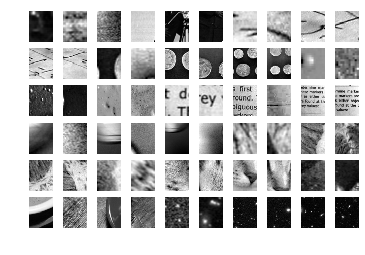

In [5]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

# Combinar muestras y extraer características HOG

In [6]:
X_train = np.array([feature.hog(im, block_norm='L1') for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

X_train.shape

(43233, 1215)

# Entrenando el modelo SVM

Usamos SVM porque es una buena elección para el nº de dimensiones tan elevado que manejamos (1215). Elegimos la clasee `LinearSVC` porque escala mejor que `SVC`. Antes probamos con Naive Bayes Gaussiano para ver cómo se comporta con nuestro dataset:

In [7]:
cross_val_score(GaussianNB(), X_train, y_train, cv=3)

array([0.94233572, 0.85844147, 0.94157241])

La precisión supera el 90% con este algoritmo tan simple. Vamos a probar SVM con validación cruzada sobre el parámetro C:

In [8]:
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]}, cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.9860985821016354

In [9]:
grid.best_params_

{'C': 8.0}

Cogemos el valor óptimo de C y reentrenamos el modelo:

In [10]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=8.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# Probando nuevas imágenes

Vamos a usar la imagen de una astronauta:

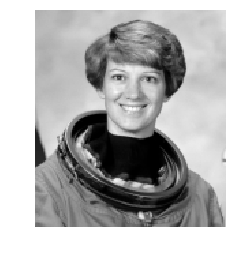

In [11]:
test_image = data.astronaut()
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.5, anti_aliasing=True, mode='reflect', multichannel=False)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

Creamos una ventana que itera sobre fragmentos de la imagen y calcula las características HOG para cada celda:

In [12]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch, block_norm='L1') for patch in patches])
patches_hog.shape

(1911, 1215)

Finalmente usamos las características extraídas por celda, y usamos el modelo para evaluar si cada celda contiene un cara:

In [13]:
labels = model.predict(patches_hog)
labels.sum()

37.0

En las 1911 piezas se han detectado 37 caras:

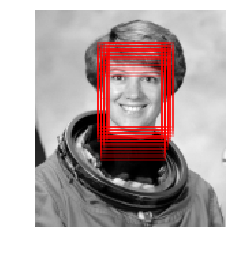

In [14]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

El procedimiento tiene posibilidad de mejoras, pero como simple demostración de HOG es más que suficiente.